In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Dataset Path
DATASET_PATH = "/content/drive/MyDrive/SER_Dataset/Ravdess/"
PROCESSED_DATA_DIR = "/content/drive/MyDrive/SER_Dataset/processed_data"
AUDIO_TYPES = ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]
ACTORS = [f"Actor_{i}" for i in range(1, 25)]

# Ensure processed data directories exist
for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(PROCESSED_DATA_DIR, folder), exist_ok=True)

# Emotion labels mapping
EMOTION_MAP = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}



Mounted at /content/drive


In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import cv2


In [ ]:
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    return audio, sr

def add_noise(audio):
    noise = np.random.normal(0, 0.005, audio.shape)
    return audio + noise

def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def extract_features(audio, sr):
    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    # Resize all features to the same shape (128x128)
    mel_spec = cv2.resize(mel_spec, (128, 128))
    mfcc = cv2.resize(mfcc, (128, 128))
    chroma = cv2.resize(chroma, (128, 128))

    # Stack into a 3-channel image
    feature_img = np.stack([mel_spec, mfcc, chroma], axis=-1)

    return feature_img


In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import cv2  # For resizing feature maps

# Function to Normalize Feature Maps
def normalize_features(features):
    min_val = np.min(features)
    max_val = np.max(features)
    return (features - min_val) / (max_val - min_val)  # Scale to [0,1]

def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    # Extract features
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCCs

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Extract Chroma

    # Normalize features
    mel_spec = normalize_features(mel_spec)
    mfcc = normalize_features(mfcc)
    chroma = normalize_features(chroma)

    # Resize MFCC and Chroma to match Mel-Spectrogram shape
    target_shape = mel_spec.shape  # (128, T)
    mfcc_resized = cv2.resize(mfcc, (target_shape[1], target_shape[0]))
    chroma_resized = cv2.resize(chroma, (target_shape[1], target_shape[0]))

    # Stack as 3-channel image (H, W, 3)
    features = np.stack([mel_spec, mfcc_resized, chroma_resized], axis=-1)

    return features

def preprocess_and_save():
    root_dir = "/content/drive/MyDrive/SER_Dataset/Ravdess"
    processed_data_dir = "/content/drive/MyDrive/SER_Dataset/processed_data"

    os.makedirs(processed_data_dir, exist_ok=True)

    for category in ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]:
        category_path = os.path.join(root_dir, category)

        for actor in sorted(os.listdir(category_path)):
            actor_path = os.path.join(category_path, actor)

            # Skip if it's not a directory (fixes .DS_Store issue)
            if not os.path.isdir(actor_path):
                continue

            for file in sorted(os.listdir(actor_path)):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_path, file)

                    # Extract emotion label from filename
                    emotion_label = file.split("-")[2]  # Example: 03-01-06-01-02-01-12.wav → '06'

                    # Map emotion number to category
                    emotion_dict = {
                        "01": "neutral",
                        "02": "calm",
                        "03": "happy",
                        "04": "sad",
                        "05": "angry",
                        "06": "fearful",
                        "07": "disgust",
                        "08": "surprised",
                    }
                    emotion_label = emotion_dict.get(emotion_label, "unknown")

                    save_dir = os.path.join(processed_data_dir, emotion_label)
                    os.makedirs(save_dir, exist_ok=True)

                    # Define save path
                    save_path = os.path.join(save_dir, file.replace(".wav", ".png"))

                    # ✅ **Skip processing if image already exists**
                    if os.path.exists(save_path):
                        print(f"Skipping {file}, already processed.")
                        continue  # Move to next file

                    # Process and Save Features
                    features = preprocess_audio(file_path)

                    plt.imsave(save_path, features)  # Save as RGB image
                    print(f"Processed and saved: {save_path}")

preprocess_and_save()


Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-01-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-01-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-02-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-02-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-01-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-01-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-02-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-02-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-02-01-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-

In [ ]:
import shutil
import random

def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for emotion in os.listdir(source_dir):
        emotion_path = os.path.join(source_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue  # Skip non-directory files

        images = [f for f in os.listdir(emotion_path) if f.endswith(".png")]
        random.shuffle(images)

        train_count = int(len(images) * split_ratio)
        train_files, val_files = images[:train_count], images[train_count:]

        os.makedirs(os.path.join(train_dir, emotion), exist_ok=True)
        os.makedirs(os.path.join(val_dir, emotion), exist_ok=True)

        for img in train_files:
            shutil.move(os.path.join(emotion_path, img), os.path.join(train_dir, emotion, img))

        for img in val_files:
            shutil.move(os.path.join(emotion_path, img), os.path.join(val_dir, emotion, img))

# Define Paths
source_dir = "/content/drive/MyDrive/SER_Dataset/processed_data"
train_dir = "/content/drive/MyDrive/SER_Dataset/processed_data/train"
val_dir = "/content/drive/MyDrive/SER_Dataset/processed_data/val"

split_data(source_dir, train_dir, val_dir)
print("Data split completed.")


Data split completed.


In [ ]:
import os

train_path = os.path.join(PROCESSED_DATA_DIR, "train")
val_path = os.path.join(PROCESSED_DATA_DIR, "val")

print("Train Subfolders:", os.listdir(train_path))
print("Validation Subfolders:", os.listdir(val_path))


Train Subfolders: ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'train', 'val', 'test']
Validation Subfolders: ['train', 'val', 'test', 'neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    os.path.join(PROCESSED_DATA_DIR, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    os.path.join(PROCESSED_DATA_DIR, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 1964 images belonging to 11 classes.
Found 488 images belonging to 11 classes.


In [ ]:
import os
import numpy as np
import cv2
import re  # Import regex module for better extraction

# Define directories
PROCESSED_DATA_DIR = "/content/drive/MyDrive/SER_Dataset/processed_data"
TRAIN_DIR = os.path.join(PROCESSED_DATA_DIR, "train")
VAL_DIR = os.path.join(PROCESSED_DATA_DIR, "val")

# Define image size
IMG_SIZE = (128, 128)

# Emotion label mapping
emotion_dict = {
    "neutral": 0, "calm": 1, "happy": 2, "sad": 3,
    "angry": 4, "fearful": 5, "disgust": 6, "surprised": 7
}

# Function to extract actor ID from filenames
def extract_actor_id(filename):
    # Find the last number in the filename (actor ID)
    numbers = re.findall(r'\d+', filename)  # Extract all numbers
    if numbers:
        return int(numbers[-1])  # Last number should be the actor ID
    else:
        return None  # If no numbers found, return None

# Function to load data
def load_data(directory):
    features, labels, actors = [], [], []

    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)

        if not os.path.isdir(emotion_path):
            continue

        for img_file in os.listdir(emotion_path):
            if img_file.endswith(".png"):
                img_path = os.path.join(emotion_path, img_file)

                # Read and preprocess the image
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0  # Normalize

                # Extract actor ID
                actor_id = extract_actor_id(img_file)
                if actor_id is None:
                    print(f"⚠️ Warning: Could not extract actor ID from {img_file}")
                    continue  # Skip files with no valid ID

                # Store data
                features.append(img)
                labels.append(emotion_dict[emotion])
                actors.append(actor_id)

    return np.array(features), np.array(labels), np.array(actors)

# Load Train & Validation Data
X_train, y_train, train_actors = load_data(TRAIN_DIR)
X_val, y_val, val_actors = load_data(VAL_DIR)

# Save extracted features
np.save("train_features.npy", X_train)
np.save("train_labels.npy", y_train)
np.save("train_actors.npy", train_actors)

np.save("val_features.npy", X_val)
np.save("val_labels.npy", y_val)
np.save("val_actors.npy", val_actors)

print(f"Train Features Shape: {X_train.shape}")
print(f"Train Labels Shape: {y_train.shape}")
print(f"Train Actors Shape: {train_actors.shape}")

print(f"Validation Features Shape: {X_val.shape}")
print(f"Validation Labels Shape: {y_val.shape}")
print(f"Validation Actors Shape: {val_actors.shape}")


Train Features Shape: (2452, 128, 128, 3)
Train Labels Shape: (2452,)
Train Actors Shape: (2452,)
Validation Features Shape: (1820, 128, 128, 3)
Validation Labels Shape: (1820,)
Validation Actors Shape: (1820,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, BatchNormalization, Reshape
import tensorflow.keras.backend as K

# Define GeM Pooling Layer
class GeMPooling(tf.keras.layers.Layer):
    def __init__(self, p_init=3.0, **kwargs):
        super(GeMPooling, self).__init__(**kwargs)
        self.p = tf.Variable(initial_value=p_init, trainable=True, dtype=tf.float32)  # Trainable 'p'

    def call(self, inputs):
        inputs = tf.maximum(inputs, 1e-6)  # Avoid zero gradients
        pooled = K.mean(K.pow(inputs, self.p), axis=[1, 2], keepdims=True)  # Keep spatial dimensions
        return K.pow(pooled, 1.0 / self.p)

    def get_config(self):
        config = super().get_config()
        config.update({"p_init": self.p.numpy()})
        return config

# Define AlexNet Model with GeM Pooling at the Last Layer
def AlexNet_HybridGeM(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Layer 1: Conv + ReLU + MaxPool
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid')(inputs)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2)(x)  # Keep initial max pooling

    # Layer 2: Conv + ReLU + MaxPool
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2)(x)

    # Layer 3: Conv + ReLU
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Conv + ReLU
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)

    # Layer 5: Conv + ReLU + GeM (instead of MaxPool)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GeMPooling()(x)  # Apply GeM only here

    # Flatten output before fully connected layers
    x = tf.keras.layers.Flatten()(x)

    model = Model(inputs=inputs, outputs=x, name="AlexNet_HybridGeM")
    return model

# Create AlexNet feature extractor with Hybrid GeM Pooling
feature_extractor = AlexNet_HybridGeM()

# Print Model Summary
feature_extractor.summary()


Model: "AlexNet_HybridGeM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ge_m_pooling (GeMPooling)            │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,747,200 (14.29 MB)

 Trainable params: 3,747,200 (14.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = "/content/drive/MyDrive/SER_Dataset/processed_data"
batch_size = 32
image_size = (128, 128)

# Load images for feature extraction
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

# Extract & Save Features
train_features = feature_extractor.predict(train_generator)
np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_generator.classes)


Found 2452 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 440ms/step


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
import joblib  # For saving the model

# Load extracted features and labels
X = np.load("train_features.npy")  # All extracted features
y = np.load("train_labels.npy")    # Corresponding emotion labels
subject_ids = np.load("train_actors.npy")  # Subject ID for LOSO

# Flatten & Normalize Features
X = X.reshape(X.shape[0], -1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize LOSO (Leave-One-Subject-Out)
logo = LeaveOneGroupOut()

# Store results
accuracies = []
conf_matrices = np.zeros((8, 8))  # 8 Emotion Classes

# Start LOSO cross-validation
for train_idx, test_idx in logo.split(X, y, groups=subject_ids):
    # Split Data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Normalize Features (fit scaler only on training data)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train SVM
    svm_model = SVC(kernel="linear", C=1, probability=True)
    svm_model.fit(X_train, y_train)

    # Predict
    y_pred = svm_model.predict(X_test)

    # Compute Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Compute Confusion Matrix
    conf_matrices += confusion_matrix(y_test, y_pred, labels=np.arange(8))

# Final Results
print("Average Accuracy:", np.mean(accuracies))
print("\nFinal Confusion Matrix:\n", conf_matrices)

# Save the model
joblib.dump(svm_model, "svm_model_loso.joblib")

print("Model saved successfully.")

# Optionally, print out detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=np.arange(8)))



Average Accuracy: 0.4553685897435898

Final Confusion Matrix:
 [[220.   8.  31.  35.  42.   6.  26.   8.]
 [  7. 239.  15.  21.  26.  16.  48.   4.]
 [ 42.  11.  92.   8.  12.   3.  16.   8.]
 [ 51.  24.  11. 154.  57.  11.  52.  16.]
 [ 57.  39.  16.  60. 133.  18.  25.  28.]
 [ 10.  22.   8.   7.  16.  95.  25.   5.]
 [ 33.  75.  17.  64.  34.  25. 116.  12.]
 [ 26.   2.  22.  31.  23.  13.   5.  70.]]
Model saved successfully.

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.75      0.63        16
           1       0.56      0.53      0.55        17
           2       0.50      0.57      0.53         7
           3       0.62      0.50      0.55        16
           4       0.54      0.44      0.48        16
           5       0.25      0.67      0.36         3
           6       0.47      0.38      0.42        21
           7       0.57      0.50      0.53         8

    accuracy                           0.52       104


 Starting LOSO Cross-Validation...
Fold 1/24 - Leaving Out Actor 1
Fold 2/24 - Leaving Out Actor 2
Fold 3/24 - Leaving Out Actor 3
Fold 4/24 - Leaving Out Actor 4
Fold 5/24 - Leaving Out Actor 5
Fold 6/24 - Leaving Out Actor 6
Fold 7/24 - Leaving Out Actor 7
Fold 8/24 - Leaving Out Actor 8
Fold 9/24 - Leaving Out Actor 9
Fold 10/24 - Leaving Out Actor 10
Fold 11/24 - Leaving Out Actor 11
Fold 12/24 - Leaving Out Actor 12
Fold 13/24 - Leaving Out Actor 13
Fold 14/24 - Leaving Out Actor 14
Fold 15/24 - Leaving Out Actor 15
Fold 16/24 - Leaving Out Actor 16
Fold 17/24 - Leaving Out Actor 17
Fold 18/24 - Leaving Out Actor 18
Fold 19/24 - Leaving Out Actor 19
Fold 20/24 - Leaving Out Actor 20
Fold 21/24 - Leaving Out Actor 21
Fold 22/24 - Leaving Out Actor 22
Fold 23/24 - Leaving Out Actor 23
Fold 24/24 - Leaving Out Actor 24

LOSO Cross-Validation Completed.

 Classification Report:
               precision    recall  f1-score   support

           0     0.5995    0.6569    0.6269       37

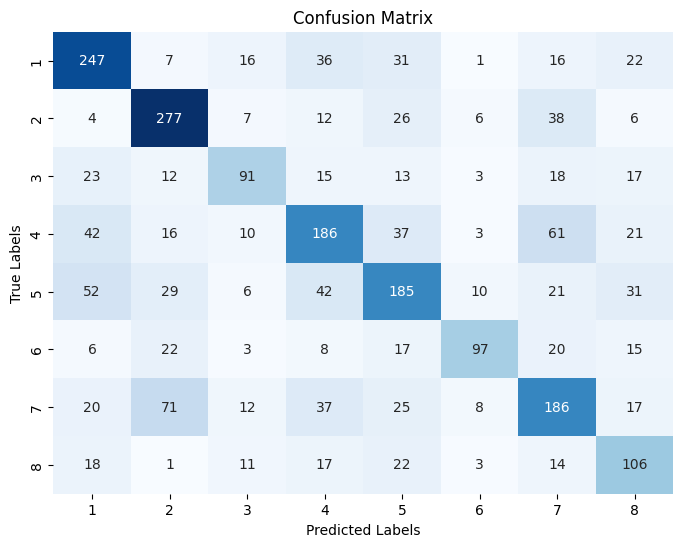

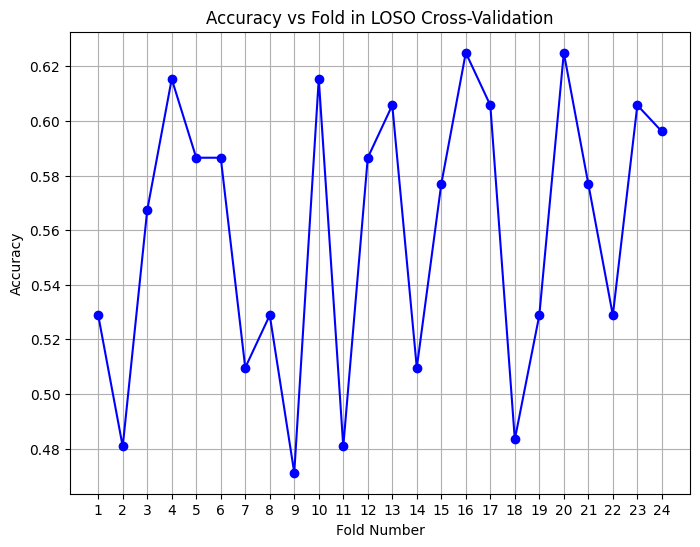

['/content/drive/MyDrive/SER_Model/scaler.joblib']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

# Load Extracted Features & Labels
X_train = np.load("train_features.npy")
y_train = np.load("train_labels.npy")

# Load Actor IDs for LOSO
actors = np.load("train_actors.npy")  # Ensure this file contains actor IDs

# Initialize Leave-One-Subject-Out (LOSO) Cross-Validation
logo = LeaveOneGroupOut()
y_true_all, y_pred_all = [], []
fold_accuracies = []

# Normalize the data (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Initialize SVM Classifier (RBF kernel)
svm_model = SVC(kernel="rbf", C=1, gamma='scale', probability=True)  # You can adjust these hyperparameters

print(" Starting LOSO Cross-Validation...")

# Perform LOSO Evaluation
for fold, (train_idx, test_idx) in enumerate(logo.split(X_train, y_train, actors), 1):
    print(f"Fold {fold}/{len(np.unique(actors))} - Leaving Out Actor {actors[test_idx][0]}")

    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    # Train the model on the fold data
    svm_model.fit(X_train_fold, y_train_fold)

    # Evaluate Model
    y_pred_fold = svm_model.predict(X_test_fold)
    y_true_fold = y_test_fold

    # Store Results
    y_true_all.extend(y_true_fold)
    y_pred_all.extend(y_pred_fold)

    # Calculate Validation Accuracy for Current Fold
    fold_accuracy = accuracy_score(y_true_fold, y_pred_fold)
    fold_accuracies.append(fold_accuracy)

print("\nLOSO Cross-Validation Completed.")

# Print Evaluation Metrics
print("\n Classification Report:\n", classification_report(y_true_all, y_pred_all, digits=4))
print(" Confusion Matrix:\n", confusion_matrix(y_true_all, y_pred_all))
print(" Overall Accuracy:", accuracy_score(y_true_all, y_pred_all))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", cbar=False, xticklabels=np.arange(1, 9), yticklabels=np.arange(1, 9))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot Accuracy vs Fold
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs Fold in LOSO Cross-Validation")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(fold_accuracies) + 1))
plt.grid(True)
plt.show()

# Save the SVM model and scaler
joblib.dump(svm_model, "/content/drive/MyDrive/SER_Model/svm_classifier.joblib")
joblib.dump(scaler, "/content/drive/MyDrive/SER_Model/scaler.joblib")
